# Using the MNIST dataset with Kosh

Assumes pytorch example repo is clone at same level as kosh repo

pytorch examples repo is [here](https://github.com/pytorch/examples.git)

```
git clone https://github.com/pytorch/examples ../../pytorch_examples
cd ../../pytorch_examples/mnist
python main.py
```



In [1]:
import os
import kosh
from  kosh import KoshLoader

# Make sure local file is new sql file
kosh_example_sql_file = "kosh_mnist_example.sql"
    
# Create db on file
store = kosh.connect(kosh_example_sql_file, delete_all_contents=True)

In [2]:
# Add MNST datasets to store
train_set = store.create(name="train10k", metadata={'project':"MNIST"})
test_set = store.create(name="test", metadata={'project':"MNIST"})

In [3]:
# Associate files with datasets
train_set.associate("../../pytorch_examples/data/MNIST/raw/train-images-idx3-ubyte", mime_type="mnist")
test_set.associate("../../pytorch_examples/data/MNIST/raw/t10k-images-idx3-ubyte", mime_type="mnist")

'cf5ba05a29bd427984000be26883d78b'

In [4]:
import struct
import numpy
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

def load_from_mnst(uri, index):
    with open(uri, "rb") as f:
        magic, nitems = struct.unpack(">2i", f.read(8))
        if magic == 2051:
            rows, columns = struct.unpack(">ii", f.read(8))
            #print(rows, columns)
            item_size = rows*columns
        else:
            item_size = 1
        offset = item_size*index
        f.seek(offset, 1)
        data = struct.unpack(">{}b".format(item_size), f.read(item_size))
        if magic == 2051:
            data = (numpy.array(data, dtype=numpy.float32)) / 255.
            data.shape = (columns, rows, 1)
        else:
            data = numpy.array(data[0])
    return data


transform_init = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
#transform_init = None
class MNSTLoader(KoshLoader, Dataset):
    types = {"mnist": ["numpy",]}
    def __init__(self, obj, transform=transform_init):
        KoshLoader.__init__(self,obj)
        Dataset.__init__(self)
        self.transform = transform

    def __len__(self):
        with open(self.obj.uri, "rb") as f:
            magic, nitems = struct.unpack(">2i", f.read(8))
        return nitems
        
    def __getitem__(self, key):
        if isinstance(key, slice):
            step = key.step
            start = key.start
            stop = key.stop
            if step is None:
                step = 1
            if start is None:
                start = 0
            if stop is None:
                stop = len(self)
            r = range(start, stop, step)
        else:
            r = range(key, key+1)
            
        if torch.is_tensor(key):
            key = key.tolist()
            
        out = ()
        for index in r:
            data = load_from_mnst(self.obj.uri, index)
            lbl = self.obj.uri.replace("image", "label").replace("idx3", "idx1")
            if os.path.exists(lbl):
                lbl = load_from_mnst(lbl, index)
            else:
                lbl = None
            if self.transform is not None:
                data = self.transform(data)
            out += ((data, lbl),)
        if len(out) > 1:
            return out
        else:
            return out[0]

    def extract(self, *args, **kargs):
        feature = self.feature
        if not feature in self.list_features():
            raise RuntimeError("unknow feature: {}".format(feature))

        if len(args) == 0:
            data = self[:]
        else:
            data = self[args]
        if feature == "image":
            return [d[0] for d in data]
        elif feature == "label":
            return [d[1] for d in data]
        else:
            return data
            
    def list_features(self):
        return ["image", "label", "both"]

store.add_loader(MNSTLoader)

In [5]:
train_set.list_features()

['image', 'label', 'both']

<bound method KoshExecutionGraph.__getitem__ of <kosh.exec_graphs.core.KoshExecutionGraph object at 0x2aaab53f1f28>>
2


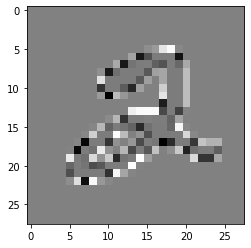

In [6]:
feature = train_set["both"]
print(feature.__getitem__)
indx = 5
img, lbl = feature
print(lbl)
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img[0], cmap="gray")
#train_img.open()

In [7]:
feature[5][0].max()

tensor(1.1795)

In [8]:
i5 = train_set.open()[5:8]

In [9]:
type(i5[-1][0])

torch.Tensor

In [10]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_set.open(), batch_size=4,
                        shuffle=True, num_workers=4)



In [11]:
# Stolen from pytorch example mnist
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


use_cuda = False
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # Training settings
import argparse
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=1, metavar='N',
                    help='number of epochs to train (default: 1)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=20, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args(())
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    train_set.open(),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_set.open(),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302874
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.300832
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.290337
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.292227
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.272207
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.272370
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.268802
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.240577
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.252538
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.219723
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.195791
Train Epoch: 1 [14080/60000 (23%)]	Loss: 2.125459
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.081810
Train Epoch: 1 [16640/60000 (28%)]	Loss: 2.006086
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.864805
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.845656
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.726316
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.374224
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.349322
Train Epoch: 1 [24320/60000 (41%)]	Loss: 1.199437
Train Epoch: 1 [